In [1]:
import numpy as np
import thinkstats2
import thinkplot
import random
import nsfg

thinkstats2.RandomSeed(17)

# 10. 线性最小二乘法
本章代码位于`linear.py`中。

## 10.1 最小二乘法拟合
相关系数度量变量关系的强弱和正负，但并不关注关系的斜率。估计斜率有几种方法，最常用的是`线性最小二乘法拟合`（linear least squares fit）。`线性拟合`是用一条线对变量关系进行建模。`最小二乘法`拟合实现线与数据之间的均方差最小。

假设我们要将一个点序列$ys$表示成另一个序列$xs$的函数。如果$xs$和$ys$之间存在线性关系，截距为$inter$，斜率为$slope$，那么我们就可以预期：
+ $y[i] = \rm{inter} + \rm{slope} * x[i]$

但是，除非完全相关，否则我们的预测只能是近似的。实际数据到拟合线的竖直偏移或`残差`（residual）为：
+ $\rm{res} = y[i] - (\rm{inter} + \rm{slope} * x[i])$

残差可能由随机因素导致，如测量误差，也可能由未知的非随机因素导致。例如，如果我们试图预测通过身高计算体重的函数，那么未知因素可能有饮食、锻炼及体型等。

如果参数$inter$和$slope$的估计错误，那么残差就会变大，因此我们很自然地希望选择的参数能使残差最小。

我们可以选择使残差的绝对值最小、平方值最小，或者立方值最小，但是最常见的做法是使残差平方和最小。为什么这样做呢？我们有3个很好的理由，还有一个不那么重要的理由：
1. 平方值和残差的正负没有关系，这正是我们通常希望的
2. 平方值使较大的残差具有更多的权重，但又不至于使最大的残差作用过大
3. 如果残差不相关，符合均值为0且方差为常数（但未知）的正态分布，那么最小二乘法拟合也是$inter$和$slope$的最大似然估计量，参见[Wikipedia](https://en.wikipedia.org/wiki/Linear_regression)
4. 使残差平方最小的$inter$和$slope$的值有很好的算法

最小二乘法拟合计算速度快，容易实现，而且通常结果也不错。

## 10.2 实现
`thinkstats2`提供了一些简单函数，演示线性最小二乘法的实现：

```python
def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope
```

`LeastSquares`以序列$xs$和$ys$为参数，返回估计参数$inter$和$slope$。其中的原理可以参考[Wikipedia](http://wikipedia.org/wiki/Numerical_methods_for_linear_least_squares)。

`thinkstats2`还提供`FitLine`函数，它以$inter$和$slope$为参数，返回序列$xs$的拟合线：

```python
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys
```

我们可以使用这些函数，计算由母亲年龄得到新生儿体重函数的最小二乘法拟合：

In [2]:
# 准备数据
preg = nsfg.ReadFemPreg(dct_file='datasets/2002FemPreg.dct',  dat_file='datasets/2002FemPreg.dat.gz')

live = preg[preg.outcome == 1]
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_lb

inter, slope = thinkstats2.LeastSquares(ages, weights)
fit_xs, fit_ys = thinkstats2.FitLine(ages, inter, slope)
(inter, slope)

(6.830396973311053, 0.017453851471802746)

计算得到的截距和斜率估计值分别为6.8磅和每年0.017磅。如果我们将截距解释为母亲0岁时新生儿的预期体重，这听起来没什么道理，而斜率又非常小，实在很难解释。

我们可以抛开$x = 0$时的截距，转而讨论在$x$均值处的截距。在我们的数据中，母亲的年龄均值为25岁，那么25岁母亲产下的婴儿的平均体重为7.3磅。斜率为每年0.27盎司，或每10年0.17磅。

下图展示了新生儿体重和母亲年龄的散点图以及拟合线。查看这种图表，我们可以估计变量关系是否为线性，拟合线是否很好地反映了变量关系。这通常是种不错的做法：

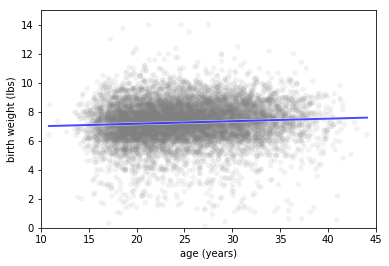

<Figure size 576x432 with 0 Axes>

In [3]:
thinkplot.Scatter(ages, weights, color='gray', alpha=0.1)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='blue', linewidth=2)
thinkplot.Show(root='linear1', xlabel='age (years)', ylabel='birth weight (lbs)', axis=[10, 45, 0, 15], legend=False)

## 10.3 残差
还有一种有用的检验方法，即`绘制残差`。`thinkstats2`提供一个计算残差的函数：

```python
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res
```

`Residuals`的参数是序列$xs$和$ys$，以及估计参数$inter$和$slope$。`Residuals`返回实际值和拟合线之间的差值。

为了对残差进行可视化展示，我把调查参与者按年龄分组，用7.2节中的做法计算每组的百分位秩。下图展示了每个年龄组残差的第25、第50和第75百分位秩。正如我们预期的，中位数值接近0，四分位距约为2磅。因此，如果我们已知母亲的年龄，就可以有50%的概率将新生儿的体重估计精确到磅：

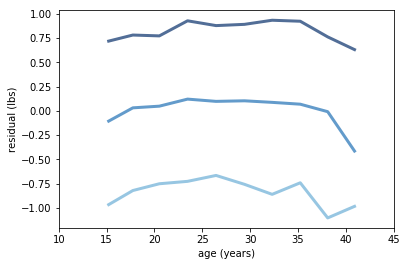

<Figure size 576x432 with 0 Axes>

In [4]:
live['residual'] = thinkstats2.Residuals(ages, weights, inter, slope)

bins = np.arange(10, 48, 3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

ages = [group.agepreg.mean() for _, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    weights = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(ages, weights, label=label)

thinkplot.Show(root='linear2', xlabel='age (years)', ylabel='residual (lbs)', xlim=[10, 45])

理想情况下，这些线应该是平的，说明残差是随机的；这些线还应该是平行的，说明所有年龄组的残差方差都很小。实际上，图中这些线接近平行，这一点很不错。但是这些线都弯弯曲曲的，说明关系是非线性的。尽管如此，线性拟合仍然是可能满足某些需求的不错的简单模型。

## 10.4 估计
参数$\rm slope$和$\rm inter$是基于样本估计得到的，因而也和其他估计值一样，会受到`抽样偏倚`、`测量误差`和`抽样误差`的影响（第8章讨论过，`抽样偏倚`是由不具代表性的样本导致的，`测量误差`是在数据收集和记录过程中产生的，测量样本而非测量总体则会产生`抽样误差`）。

为了估计抽样误差，我们会问：“如果再次运行这个实验，我们预期估计值会有多大变化？”要回答这个问题，我们可以运行模拟实验，计算估计值的抽样分布。

我模拟实验的方法是对数据进行重抽样，也就是说，将观测到的妊娠数据作为整个总体，从这个观测样本中进行放回抽样：

In [5]:
def SamplingDistributions(live, iters=101):
    t = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = thinkstats2.LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

`SamplingDistributions`的参数之一为`DataFrame`，其中每个成功生产数据为一行，另一个参数是待模拟的实验次数`iters`。

完成重抽样后，我们使用模拟样本来估计参数。结果为两个序列：`截距估计值`和`斜率估计值`。

最后，我们将这个抽样分布的标准误差和置信区间打印出来。

In [6]:
def Summarize(estimates, actual=None):
    mean = thinkstats2.Mean(estimates)
    stderr = thinkstats2.Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

`Summarize`的参数是估计值和实际值序列，打印估计值的均值、标准误差和90%置信区间。

我们计算得到截距估计值的均值为6.83，标准误差为0.07，90%置信区间为(6.71, 6.94)。斜率估计值的结果可以写为：0.0174、SE 0.0028和CI (0.0126, 0.0220)。斜率估计值CI的最大值几乎是最小值的两倍，应视为粗略估计。

为了可视化地展示这个估计的抽样误差，我们可以绘制出所有的拟合线。或者，简洁起见，我们可以绘制每个年龄的90%置信区间。代码如下：

In [7]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = thinkstats2.FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

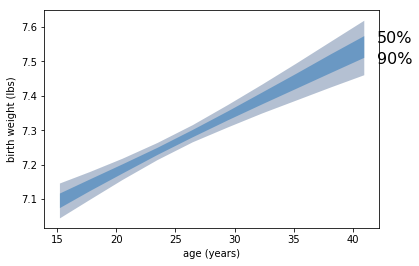

<Figure size 576x432 with 0 Axes>

In [8]:
inters, slopes = SamplingDistributions(live, iters=1001)
PlotConfidenceIntervals(ages, inters, slopes, percent=90,  alpha=0.3, label='90% CI')

thinkplot.Text(42, 7.53, '90%')
PlotConfidenceIntervals(ages, inters, slopes, percent=50, alpha=0.5, label='50% CI')
thinkplot.Text(42, 7.59, '50%')
    
thinkplot.Show(root='linear3', xlabel='age (years)', ylabel='birth weight (lbs)', legend=False)

`DiffMeansOneSided`从父类`DiffMeansPermute`继承了`MakeModel`和`RunModel`方法，唯一的不同是`TestStatistic`方法计算的是组一均值减去组二均值，没有取绝对值。这种检验只检查差值分布的一侧，因此称为`单侧的（one-sided）检验`。之前的检验使用差值分布的两侧，因而称为`双侧的（two-sided）检验`。

这一版本测试得到的`p值`为0.09。单侧检验的`p值`通常约为双侧检验`p值`的一半，但会受分布形状的影响。

我们的单侧假设为第一胎出生较晚，这个假设比双侧假设更为具体，因此`p值`较小。但即便对于这个更具体的假设，差值也不是统计显著的。

我们可以使用同样的框架检验标准差的差值。在`3.3节`中，有一些证据显示第一胎更可能提早或推迟出生，较少准时。因此，我们可以假设第一胎妊娠时间的标准差更高。检验方法如下：

In [9]:
class DiffStdPermute(DiffMeansPermute):
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

NameError: name 'DiffMeansPermute' is not defined

我们的假设是第一胎的标准差更高，而不仅仅是不同，因此这个检验是单侧检验。检验得到的`p值`为0.09，不是统计显著的。

## 9.5 检验相关性
这个框架也可以检验相关性。例如，在全国家庭增长调查数据集中，新生儿体重和母亲年龄的相关性约为0.07。年龄较大的母亲似乎产下的孩子更重。但是，这种效应是偶然产生的吗？

可以选择`Pearson相关性`作为检验统计量，但`Spearman相关性`也是很好的选择。如果我们有理由预期正相关，那么就可以进行单侧检验。但由于我们并没有任何相关证据，因此还是选择使用相关性的绝对值进行双侧检验。

检验的原假设是母亲年龄和新生儿体重之间没有相关性。我们可以将观察值混排进行模拟，在这个模拟世界中，母亲年龄和新生儿体重的分布仍保持不变，但这两个变量之间没有相关性。

In [ ]:
class CorrelationPermute(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

`data`是一对序列。`TestStatistic`计算`Pearson相关性`的绝对值。`RunModel`将xs进行混排，返回模拟数据。

下面一段代码读取数据并运行检验：

In [ ]:
live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
data = live2.agepreg.values, live2.totalwgt_lb.values
ht = CorrelationPermute(data)
p_value = ht.PValue()
pvalue

> **原文这段话没看明白**
> 实际数据的相关性为0.07。检验计算得到的 p 值为0。在1000次重复实验中，模拟得到的最大相关性为0.04。因此，虽然观察到的变量相关性很小，但这种相关性是统计显著的。

这个示例提醒我们，`统计显著`并不一定说明一个效应是重要的，或者在实践中是显著的。`统计显著`只说明一个效应不太可能是偶然产生的。

## 9.6 检验比例
假设你经营一家赌场，怀疑一位顾客使用作弊骰子，也就是说这个骰子经过处理，更容易掷出其中一面。你抓住这位受怀疑的作弊者，没收了骰子，但是还必须证明这个骰子有问题。你将这个骰子掷了60次，得到如下结果：

| 点数 | 1 | 2 |  3 | 4  | 5 | 6 |
| --- | --- | --- |  --- | --- |  --- | --- |
| 频数 | 8 | 9 | 19 | 5 | 8 | 11 |

在这个数据集中，3出现的次数较多，4较少。但是，这些差异是统计显著的吗？

为了检验这个假设，我们可以计算出每个值的预期频数、预期频数与观察频数的差值，以及差值绝对值的和。在这个示例中，我们预期60次投掷里，骰子的每一面都出现10次，观察值与预期值的差值为`[-2, -1, 9, -5, -2, 1]`，差值绝对值的和为20。完全偶然出现这么大差值的概率是多少呢？

下面这个版本的`HypothesisTest`回答了这个问题：

In [ ]:
class DiceTest(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat

    def RunModel(self):
        n = sum(self.data)
        values = [1, 2, 3, 4, 5, 6]
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.Freqs(values)
        return freqs

代码中使用的数据表示一列频数。观察值为`[8, 9, 19, 5, 8, 11]`，预期频数都是10。检验统计量是差值绝对值的和。

原假设是骰子没有问题，因此我们从values中随机抽取样本进行模拟。RunModel使用Hist计算和返回频数列表。计算得到的p值为0.13，如果骰子没有问题，我们预期检验统计量达到或超过观察值的概率为13%。因此，这个直观效应不是统计显著的。

## 9.7 卡方检验
在前一节，我们使用偏差总和作为检测统计量。但是，检测比例时，人们更多使用的是`卡方统计量`：

+ $\displaystyle x^2 = \sum_{i} \frac{(O_i - E_i)^2}{E_i}$

其中$O_i$是观察到的频数， $E_i$是预期频数。计算`卡方统计量`的Python代码如下：

In [ ]:
class DiceChiTest(DiceTest):
    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat

将差值求平方（而不是取绝对值）使大偏差值的权重更大。除以`expected`可以将偏差标准化，虽然在这个例子中预期频数都相同，这种做法没有什么效果。

使用卡方统计量计算的$p$值为0.04，明显小于使用偏差和的值0.13。如果我们坚持使用5%的阈值，就会认为受检测的效应是统计显著的。但是，将这两个检验放在一起考虑，我认为结果并不明确。我无法排除骰子有问题的可能性，也不能肯定骰子一定有问题。

这个示例说明了一个重要问题：$p$值取决于检验统计量的选择和原假设模型，有时这些因素决定了一个效应是否统计显著。

## 9.8 再谈第一胎
我们在本章稍前部分研究了第一胎和其他胎的妊娠时间，认为两组样本均值和标准差的直观差异不是统计显著的。但在3.3节，我们看到了妊娠时间分布的几个直观差异，在35~43周范围内差异尤为明显。要判断这些差异是否统计显著，我们可以使用基于卡方统计量的检验。

下面一段代码结合了前几个示例的功能：

In [ ]:
class PregLengthTest(thinkstats2.HypothesisTest):
    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

`TestStatistic`计算第一胎和其他胎的卡方统计量，并求和。

`ChiSquared`以一个妊娠时间序列为参数，计算直方图及对应`self.values`的频数列表`observed`，并将预期概率`expected_probs`乘以样本大小，计算出预期频数列表，返回值为卡方统计量`stat`。

全国家庭增长调查数据的总卡方统计量为102，这个数字本身没有什么意义。但在原假设下，1000次重复产生的最大验证统计量是32。对比之下，我们认为观察到的卡方统计量在原假设下不太可能出现，因此这个直观效应是统计显著的。

这个示例说明卡方检验存在一个局限：卡方检验(chi-squared test)可以证明两个群组之间存在差异，但不能揭示这个差异是什么。

## 9.9 误差
在经典假设检验中，如果p值低于某个阈值（常用阈值为5%），那么我们就认为一个效应是统计显著的。这个过程产生了两个问题：
+ 如果一个效应的确是偶然产生的，那么我们将它误判为统计显著的概率是多少？这个概率就是`误报率`（false positive rate）
+ 如果一个效应不是偶然的，那么假设检验失败的概率是多少？这个概率称为`漏报率`（false negative rate）

相对而言，漏报率比较容易计算。如果阈值为5%，那么漏报率就是5%，理由如下：
+ 如果效应不为真，那么原假设成立，因此，通过模拟原假设就可以计算出检验统计量的分布。我们将这个分布称为$\rm CDFT$
+ 重复运行实验，每次得到一个来自$\rm CDFT$的测试统计量`t`。随后，我们计算出`p值`。`p值`是$\rm CDFT$中的随机值大于`t`的概率，即为$1-\rm CDFT(t)$
+ 当$\rm CDFT (t)$大于`95%`，即`t`大于第95百分秩时，`p值`小于5%。而$\rm CDFT$中随机抽取的值大于第95百分秩的概率为多少呢？答案是5%

因此，如果你进行一个阈值为5%的假设检验，20次里会有1次漏报。

## 9.10 功效
误报率受实际效应大小的影响，而通常我们无法得知实际效应的大小，因此误报率较难计算。一个办法是计算一个假定效应大小的误报率。

举个例子，如果我们假设观测到的组间差异是准确的，那么可以以观测样本为总体模型，使用模拟数据运行假设检验。

In [ ]:
def FalseNegRate(data, num_runs=100):
    group1, group2 = data
    count = 0

    for i in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)

        ht = DiffMeansPermute((sample1, sample2))
        pvalue = ht.PValue(iters=101)
        if pvalue > 0.05:
            count += 1

    return count / num_runs

`FalseNegRate`方法的参数`data`是两个序列，每组一个。每次循环从两组中各抽取一个随机样本，运行假设检验，以此模拟一次实验，然后检查检验结果，计算误报次数。

`Resample`方法以一个序列为参数，使用放回抽样，从中抽取相同长度的样本：
```python
def Resample(xs):
    return np.random.choice(xs, len(xs), replace=True)
```

检验妊娠时间的代码如下：

In [ ]:
neg_rate = FalseNegRate(data)
neg_rate

结果约为70%。这个结果说明，如果妊娠时间均值的实际差异为0.78周，那么我们预期，如果使用这个规模的样本进行实验，结果有70%的可能性为误报。

人们经常用另一种方式描述这个结果：如果实际差异为0.78周，那么我们预期检验通过的可能性只有30%。这个`正确通过率`称为检验的`功效`（power），有时也称为`敏感度`（sensitivity）。这个值反映了一个检验检测出指定大小效应的能力。

在这个示例中，这个检验结果通过的可能性只有30%（假设实际差异为0.78周）。一般说来，我们认为80%的功效是可接受的，因此示例中的检验属于`低功效的`（underpowered）。

通常，假设检验失败并不说明两个群组之间不存在差异，而是说，如果差异的确存在的话，这个差异太小，以至于无法在这种规模的样本中检测到。

## 9.11 复现
严格说来，我在本章演示的假设检验过程并非最佳实践：
+ 首先，我进行了多重检验。如果你运行一个假设检验，那么误报的可能性约为1/20，还在可接受范围内。但是，如果运行20个检验，那么在大多数情况下，你至少应该预期得到1次误报
+ 其次，我使用同一个数据集进行探索和检验。如果你对一个大数据集进行探索性研究，发现了一个惊人的效应，然后又检验这个效应是否显著，结果十有八九会是误报

要弥补多重检验的问题，你可以调整 p 值的阈值，[参见](https://en.wikipedia.org/wiki/Holm-Bonferroni_method)。你也可以选择将数据分区，一部分数据用来探索，另一部分用来检验，如此，上面提到的问题都可以得到解决。

在某些领域，这些弥补或解决方法是必须采取的，或者至少是受到鼓励的。但是我们通常也可以通过重现别人发表的结果，间接解决这些问题。通常，人们将报告某个新发现的第一篇论文视为探索性的，使用新数据复现该结果的后续论文则为验证性的。

实际上，我们的确有机会复现本章的结果。本书第一版使用的是全国家庭增长调查的第6周期数据，发布于2002年。在2011年10月，疾病控制和预防中心发布了基于2006~2010年调查的附加数据。nsfg2.py中包含读取和清洗这些数据的代码。在这个新数据集中：
+ 妊娠时间均值差为0.16周，$p < 0.001$，是统计显著的（原始数据中均值差为0.078周）
+ 新生儿体重的差值为0.17磅，$p < 0.001$（原始数据中差值为0.12磅）
+ 新生儿体重与母亲年龄之间的相关性为0.08，$p < 0.001$（原始数据中相关性为0.07）
+ 卡方差检验结果$p < 0.001$，是统计显著的（原始数据中也是如此）

总之，原始数据中所有统计显著的效应，在新数据集中都得到了复现。此外，妊娠时间差值在原始数据中不显著，在新数据集中这个差值变大，由不显著变为显著。